# Analysis of validation experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [8]:
validation = pd.read_excel('B-ALL validation.xlsx')

#exclude gRNA 4
validation = validation[validation['sgRNA']!='ABE4']

holder = []
for i in np.unique(validation['sgRNA']):
    initial_perc = validation[(validation['sgRNA']==i) & (validation['Timepoint']=='Initial')]['Percent_population'].values[0]
    subset = validation[validation['sgRNA']==i]
    subset['FoldChange'] = np.asarray(subset['Percent_population'])/initial_perc
    subset['LFC'] = np.log2(np.asarray(subset['Percent_population'])/initial_perc)
    holder.append(subset)

validation_lfc = pd.concat(holder)


gRNA_dict = {'ABE2':'gRNA_13607',
'ABE1':	'gRNA_12604',
'ABE8':	'gRNA_2474',
'ABE15': 'gRNA_12386',
'ABE3':	'gRNA_2458',
'ABE17':'gRNA_11607',
'CBE13': 'gRNA_10211',
'CBE14':'gRNA_4802',
'CBE16':'gRNA_13292',
'ABE6':	'gRNA_10342',
'ABE10': 'gRNA_12164',
'CBE9':	'gRNA_12312',
'CBE11':'gRNA_8280',
'CBE12':'gRNA_10131'}
#'ABE12':'gRNA_31',


validation_lfc['gRNA_id'] = [gRNA_dict[i] for i in validation_lfc['sgRNA']]

ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
ABE_info = ABE_LFC[['gRNA_id', 'Gene', 'gene_name_h', 'HGVSp_m', 'HGVSp_h', 'classification']]
ABE_info['Editor']='ABE'

CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')
CBE_info = CBE_LFC[['gRNA_id', 'Gene', 'gene_name_h', 'HGVSp_m', 'HGVSp_h', 'classification']]
CBE_info['Editor']='CBE'

comb_info = pd.concat((ABE_info, CBE_info))

validation_merged = pd.merge(validation_lfc, comb_info, on='gRNA_id')

validation_merged['Name'] = [f'{val["gene_name_h"]} {val["HGVSp_h"]} \n{val["Gene"]} {val["HGVSp_m"]}' for i, val in validation_merged.iterrows()]
validation_merged

,sgRNA,Percent_population,Timepoint,Tissue,FoldChange,LFC,gRNA_id,Gene,gene_name_h,HGVSp_m,HGVSp_h,classification,Editor,Name
0,ABE1,16.6,Initial,In Vitro,1.000000,0.000000,gRNA_12604,Trp53,TP53,R277G,R280G,targeting guide,ABE,TP53 R280G \nTrp53 R277G
1,ABE1,22.6,Final,In Vitro,1.361446,0.445140,gRNA_12604,Trp53,TP53,R277G,R280G,targeting guide,ABE,TP53 R280G \nTrp53 R277G
2,ABE1,25.2,Final,In Vitro,1.518072,0.602240,gRNA_12604,Trp53,TP53,R277G,R280G,targeting guide,ABE,TP53 R280G \nTrp53 R277G
3,ABE1,20.8,Final,In Vitro,1.253012,0.325400,gRNA_12604,Trp53,TP53,R277G,R280G,targeting guide,ABE,TP53 R280G \nTrp53 R277G
4,ABE1,69.6,Final,Spleen,4.192771,2.067904,gRNA_12604,Trp53,TP53,R277G,R280G,targeting guide,ABE,TP53 R280G \nTrp53 R277G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,CBE9,18.8,Final,Bone Marrow,1.553719,0.635726,gRNA_12312,Tek,TEK,R167W,R167W,targeting guide,CBE,TEK R167W \nTek R167W
247,CBE9,29.2,Final,Meninges,2.413223,1.270961,gRNA_12312,Tek,TEK,R167W,R167W,targeting guide,CBE,TEK R167W \nTek R167W
248,CBE9,22.7,Final,Meninges,1.876033,0.907685,gRNA_12312,Tek,TEK,R167W,R167W,targeting guide,CBE,TEK R167W \nTek R167W
249,CBE9,36.0,Final,Meninges,2.975207,1.572990,gRNA_12312,Tek,TEK,R167W,R167W,targeting guide,CBE,TEK R167W \nTek R167W


In [14]:
#and do the comparison
guides = np.unique(validation_merged['gRNA_id'])

ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')
ABE_LFC['Editor']='ABE'
CBE_LFC['Editor']='CBE'

a2 = pd.concat((ABE_LFC, CBE_LFC))
screen_data = a2[a2['gRNA_id'].isin(guides)]

sp = ['spleen1', 'spleen2', 'spleen3', 'spleen4', 'spleen5', 'spleen6','spleen7', 'spleen8', 'spleen9']
bm = ['bonemarrow1', 'bonemarrow2','bonemarrow3', 'bonemarrow4', 'bonemarrow5','bonemarrow6', 'bonemarrow7','bonemarrow8', 'bonemarrow9', 'bonemarrow10']
men = ['meninges1', 'meninges2', 'meninges3','meninges4', 'meninges5','meninges6', 'meninges7','meninges8', 'meninges9', 'meninges10']
iv = ['d15_rep1','d15_rep2', 'd15_rep3']


sp_std = []
bm_std = []
men_std = []
iv_std = []
for i, val in screen_data.iterrows():
    g = val['gRNA_id']
    subset = screen_data[screen_data['gRNA_id']==g]
    sp1 = np.asarray(subset[sp].dropna(axis=1))
    men1 = np.asarray(subset[men].dropna(axis=1))
    bm1 = np.asarray(subset[bm].dropna(axis=1))
    iv1 = np.asarray(subset[iv].dropna(axis=1))

    sp_std.append(np.std(sp1))
    bm_std.append(np.std(bm1))
    men_std.append(np.std(men1))
    iv_std.append(np.std(iv1))

screen_data['spleen_std'] = sp_std
screen_data['bm_std'] = bm_std
screen_data['meninges_std'] = men_std
screen_data['iv_std'] = iv_std

screen_data_medians = screen_data[['gRNA_id', 'LFC_median_meninges', 'LFC_median_spleen', 'LFC_median_bonemarrow', 'LFC_median_d15', 'Editor', 'spleen_std', 'bm_std', 'meninges_std', 'iv_std']]


data_val = pd.DataFrame(dict(zip(['gRNA_id', 'median_Meninges', 'median_Spleen', 'median_In Vitro', 'median_Bone Marrow'], [guides, np.zeros(len(guides)),np.zeros(len(guides)),np.zeros(len(guides)),np.zeros(len(guides))])))

for guide in guides:

    subset = validation_merged[(validation_merged['gRNA_id']==guide) & (validation_merged['Timepoint']=='Final')]

    for k in ['In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']:
        lfcs = subset[subset['Tissue']==k]['LFC']
        med = np.median(lfcs)
        std = np.std(lfcs)

        data_val.loc[data_val['gRNA_id']==guide, f'median_{k}'] = med
        data_val.loc[data_val['gRNA_id']==guide, f'std_{k}'] = std

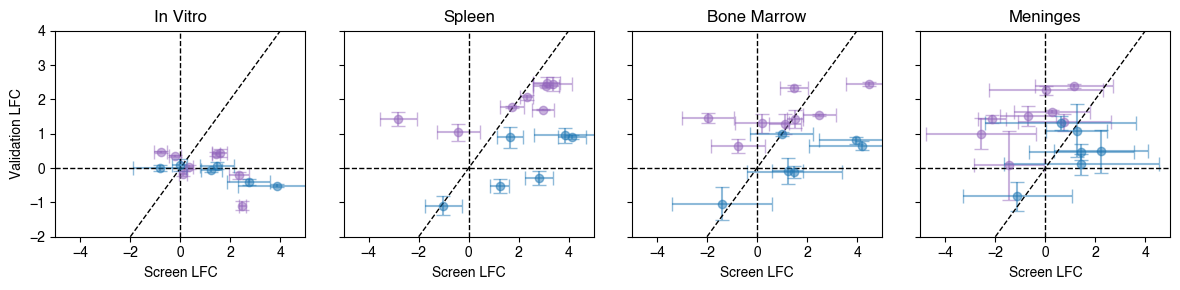

In [16]:
m1 = pd.merge(screen_data_medians, data_val, on='gRNA_id')
m1_ABE = m1[m1['Editor']=='ABE']
m1_CBE = m1[m1['Editor']=='CBE']

fig, ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)


#first plot ABE in errorbar format
ax[0].errorbar(m1_ABE['LFC_median_d15'], m1_ABE['median_In Vitro'], xerr=m1_ABE['iv_std'], yerr=m1_ABE['std_In Vitro'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[0].errorbar(m1_CBE['LFC_median_d15'], m1_CBE['median_In Vitro'], xerr=m1_CBE['iv_std'], yerr=m1_CBE['std_In Vitro'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[0].set_title('In Vitro')

ax[1].errorbar(m1_ABE['LFC_median_spleen'], m1_ABE['median_Spleen'], xerr=m1_ABE['spleen_std'], yerr=m1_ABE['std_Spleen'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[1].errorbar(m1_CBE['LFC_median_spleen'], m1_CBE['median_Spleen'], xerr=m1_CBE['spleen_std'], yerr=m1_CBE['std_Spleen'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[1].set_title('Spleen')


ax[2].errorbar(m1_ABE['LFC_median_bonemarrow'], m1_ABE['median_Bone Marrow'], xerr=m1_ABE['bm_std'], yerr=m1_ABE['std_Bone Marrow'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[2].errorbar(m1_CBE['LFC_median_bonemarrow'], m1_CBE['median_Bone Marrow'], xerr=m1_CBE['bm_std'], yerr=m1_CBE['std_Bone Marrow'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[2].set_title('Bone Marrow')


ax[3].errorbar(m1_ABE['LFC_median_meninges'], m1_ABE['median_Meninges'], xerr=m1_ABE['meninges_std'], yerr=m1_ABE['std_Meninges'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
ax[3].errorbar(m1_CBE['LFC_median_meninges'], m1_CBE['median_Meninges'], xerr=m1_CBE['meninges_std'], yerr=m1_CBE['std_Meninges'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
ax[3].set_title('Meninges')

ax[0].set_ylabel('Validation LFC')


for i in range(4):
    ax[i].set_xlabel('Screen LFC')
    ax[i].axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax[i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=1)


ax[0].set_xlim(-5,5)
ax[1].set_ylim(-2,4)
fig.tight_layout()

In [31]:
data_val

,gRNA_id,median_Meninges,median_Spleen,median_In Vitro,median_Bone Marrow,std_In Vitro,std_Spleen,std_Bone Marrow,std_Meninges
0,gRNA_10131,0.484260,0.954481,-0.518193,0.652927,0.045594,0.211771,0.129598,0.629817
1,gRNA_10211,0.462478,-0.286713,0.081530,-0.104337,0.171012,0.194951,0.176461,0.234320
2,gRNA_10342,2.258599,2.392059,-0.212545,2.336889,0.106215,0.037508,0.088296,0.133458
3,gRNA_11607,1.639410,1.691878,0.409984,1.544032,0.056216,0.016218,0.032822,0.045571
4,gRNA_12164,2.393617,2.489357,-1.091630,2.446467,0.137137,0.149683,0.049413,0.065842
5,gRNA_12312,1.089323,0.901189,-0.409484,0.803871,0.088351,0.059804,0.113410,0.770283
6,gRNA_12386,1.519539,1.771376,0.340289,1.303331,0.031036,0.027170,0.283651,0.287000
7,gRNA_12604,1.328864,2.067904,0.445140,1.432315,0.113362,0.072475,0.265430,0.237005
8,gRNA_13292,-0.817384,-1.091488,0.008665,-1.038756,0.088071,0.289684,0.476189,0.422346
9,gRNA_13607,0.081794,1.035624,0.035624,0.647698,0.058267,0.248942,0.205959,1.002748


In [42]:
m1

,gRNA_id,LFC_median_meninges,LFC_median_spleen,LFC_median_bonemarrow,LFC_median_d15,Editor_x,spleen_std,bm_std,meninges_std,iv_std,...,std_Spleen,std_Bone Marrow,std_Meninges,Gene,gene_name_h,HGVSp_m,HGVSp_h,classification,Editor_y,Name
0,gRNA_2458,-2.137841,-2.807117,-1.958151,-0.783959,ABE,0.729531,1.022355,0.548701,0.260950,...,0.210270,0.155175,0.112610,Ctnnb1,CTNNB1,D32G,D32G,targeting guide,ABE,CTNNB1 D32G \nCtnnb1 D32G
1,gRNA_2474,-2.574786,3.351583,1.134223,0.113573,ABE,0.794496,0.635564,2.191732,0.156433,...,0.200004,0.297769,0.453880,Ctnnb1,CTNNB1,S45P,S45P,targeting guide,ABE,CTNNB1 S45P \nCtnnb1 S45P
2,gRNA_10342,0.039870,3.091860,1.474299,2.357751,ABE,0.530798,0.566334,2.282989,0.399397,...,0.037508,0.088296,0.133458,Raf1,RAF1,R391G,R391G,targeting guide,ABE,RAF1 R391G \nRaf1 R391G
3,gRNA_11607,0.270505,2.966590,2.492051,1.425459,ABE,0.452392,0.648289,1.508936,0.143853,...,0.016218,0.032822,0.045571,Smo,SMO,I160V,I156V,targeting guide,ABE,SMO I156V \nSmo I160V
4,gRNA_12164,1.141120,3.116857,4.488398,2.483826,ABE,0.551675,0.944218,1.561623,0.135082,...,0.149683,0.049413,0.065842,Syk,SYK,N451S,N457S,targeting guide,ABE,SYK N457S \nSyk N451S
5,gRNA_12386,-0.690195,1.730253,0.197224,-0.214787,ABE,0.479153,1.084358,1.104930,0.254223,...,0.027170,0.283651,0.287000,Tet2,TET2,S1820P,S1898P,targeting guide,ABE,TET2 S1898P \nTet2 S1820P
6,gRNA_12604,0.762700,2.321278,1.526947,1.566673,ABE,0.264397,0.325857,1.851302,0.282887,...,0.072475,0.265430,0.237005,Trp53,TP53,R277G,R280G,targeting guide,ABE,TP53 R280G \nTrp53 R277G
7,gRNA_13607,-1.444899,-0.408393,-0.763931,0.327580,ABE,0.873239,1.091382,1.405547,0.184141,...,0.248942,0.205959,1.002748,non_target,NaN,Non-coding,NaN,non-targeting control,ABE,nan nan \nnon_target Non-coding
8,gRNA_4802,1.439332,1.235812,1.228354,1.458346,CBE,0.386059,0.619338,3.100381,0.667341,...,0.205488,0.388269,0.316408,Gata3,GATA3,R275W,R275W,targeting guide,CBE,GATA3 R275W \nGata3 R275W
9,gRNA_8280,0.606190,1.649905,0.982885,1.233873,CBE,0.513054,1.257511,3.018405,0.418223,...,0.315223,0.065335,0.201749,Ntrk1,NTRK1,R652W,R649W,targeting guide,CBE,NTRK1 R649W \nNtrk1 R652W


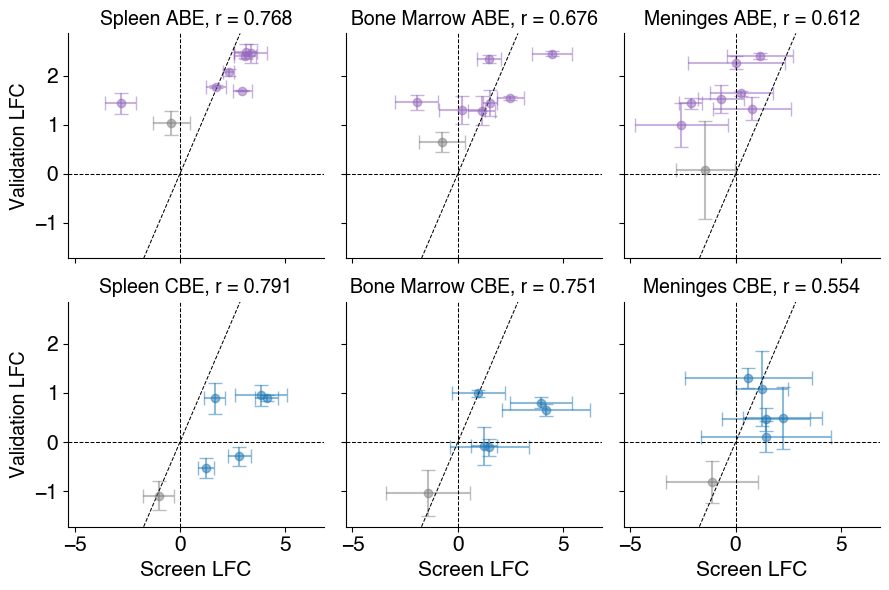

In [ ]:
#m1 = pd.merge(screen_data_medians[screen_data_medians['gRNA_id']!='gRNA_2458'], data_val, on='gRNA_id')
g_info = validation_merged[['gRNA_id', 'Gene', 'gene_name_h', 'HGVSp_m', 'HGVSp_h', 'classification', 'Name']].drop_duplicates().reset_index(drop=True)

m1 = pd.merge(screen_data_medians, data_val, on='gRNA_id')
m1 = pd.merge(m1, g_info, on='gRNA_id')

m1_ABE = m1[m1['Editor']=='ABE']
m1_CBE = m1[m1['Editor']=='CBE']

fig, ax = plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True)

name_dict = {'spleen': 'Spleen', 'bonemarrow':'Bone Marrow', 'meninges':'Meninges'}
nd2 = {'spleen': 'spleen', 'bonemarrow':'bm', 'meninges':'meninges'}
#first plot ABE in errorbar format
for i, val in enumerate(name_dict.keys()):

    k = name_dict[val]
    k2 = nd2[val]

    targ_ABE = m1_ABE[m1_ABE['classification']=='targeting guide']
    targ_CBE = m1_CBE[m1_CBE['classification']=='targeting guide']
    control_ABE = m1_ABE[m1_ABE['classification']!='targeting guide']
    control_CBE = m1_CBE[m1_CBE['classification']!='targeting guide']

    ax[0][i].errorbar(targ_ABE[f'LFC_median_{val}'], targ_ABE[f'median_{k}'], xerr=targ_ABE[f'{k2}_std'], yerr=targ_ABE[f'std_{k}'], color='tab:purple',fmt='o', capsize=5, alpha=.5)
    ax[1][i].errorbar(targ_CBE[f'LFC_median_{val}'], targ_CBE[f'median_{k}'], xerr=targ_CBE[f'{k2}_std'], yerr=targ_CBE[f'std_{k}'], color='tab:blue',fmt='o', capsize=5, alpha=.5)
    ax[0][i].errorbar(control_ABE[f'LFC_median_{val}'], control_ABE[f'median_{k}'], xerr=control_ABE[f'{k2}_std'], yerr=control_ABE[f'std_{k}'], color='tab:grey',fmt='o', capsize=5, alpha=.5)
    ax[1][i].errorbar(control_CBE[f'LFC_median_{val}'], control_CBE[f'median_{k}'], xerr=control_CBE[f'{k2}_std'], yerr=control_CBE[f'std_{k}'], color='tab:grey',fmt='o', capsize=5, alpha=.5)


    a1_p = np.round(scipy.stats.pearsonr(m1_ABE[f'LFC_median_{val}'], m1_ABE[f'median_{k}']).statistic,3)
    a2_p = np.round(scipy.stats.pearsonr(m1_CBE[f'LFC_median_{val}'], m1_CBE[f'median_{k}']).statistic,3)
    ax[0][i].set_title(f'{k} ABE, r = {a1_p}', fontsize=14)
    ax[1][i].set_title(f'{k} CBE, r = {a2_p}', fontsize=14)


ax[0][0].set_ylabel('Validation LFC', fontsize=14)
ax[1][0].set_ylabel('Validation LFC', fontsize=14)


for i in range(3):
    ax[1][i].set_xlabel('Screen LFC', fontsize=15)
    ax[0][i].axvline(0, color='black', linestyle='dashed', linewidth=.75)
    ax[1][i].axvline(0, color='black', linestyle='dashed', linewidth=.75)

    ax[0][i].axhline(0, color='black', linestyle='dashed', linewidth=.75)
    ax[1][i].axhline(0, color='black', linestyle='dashed', linewidth=.75)

    ax[0][i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=.75)
    ax[1][i].axline((1, 1), slope=1, color='black',linestyle='dashed', linewidth=.75)

    #ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
    ax[0][i].spines[['top', 'right']].set_visible(False)
    ax[1][i].spines[['top', 'right']].set_visible(False)

    ax[0][i].tick_params(axis='both', which='major', labelsize=15)
    ax[1][i].tick_params(axis='both', which='major', labelsize=15)

    #ax.tick_params(axis='y', which='major', labelsize=15)

#ax[0].set_xlim(-5,5)
#ax[1].set_ylim(-2,4)
fig.tight_layout()
#fig.savefig('figures/validation_gRNA_scatter.pdf')

<Axes: xlabel='Name', ylabel='LFC'>

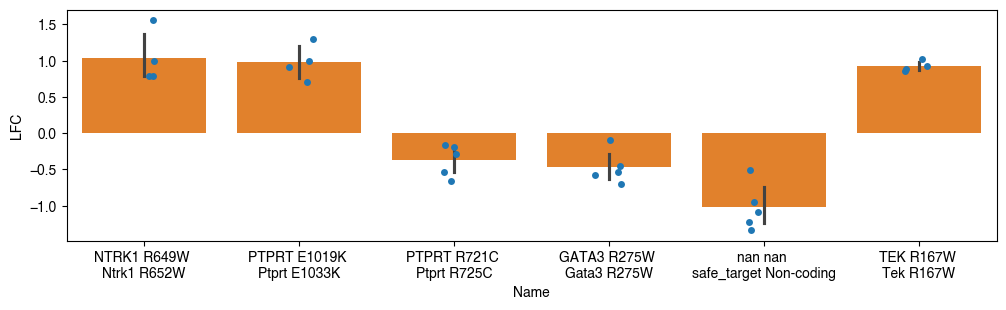

In [ ]:
val_ABE = validation_merged[(validation_merged['Editor']=='ABE') & (validation_merged['Timepoint']=='Final')]
val_CBE = validation_merged[(validation_merged['Editor']=='CBE') & (validation_merged['Timepoint']=='Final')]

fig, ax = plt.subplots(figsize=(12,3))
sns.stripplot(data=val_CBE[val_CBE['Tissue']=='Spleen'], x='Name', y='LFC')
sns.barplot(data=val_CBE[val_CBE['Tissue']=='Spleen'], x='Name', y='LFC')

In [78]:
CBE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
    'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
    'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
    'd5':['d5_rep1','d5_rep2','d5_rep3'],
    'd15':['d15_rep1','d15_rep2','d15_rep3'],
    'plasmid_lib':['plasmidlib']}

ABE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
'd5':['d5_rep1','d5_rep2','d5_rep3'],
'd15':['d15_rep1','d15_rep2','d15_rep3'],
'plasmid_lib':['plasmidlib']}

screen_data_ABE = screen_data[screen_data['Editor']=='ABE']
screen_data_CBE = screen_data[screen_data['Editor']=='CBE']


tissue_holder = []
LFC_holder = []
gRNA_holder = []

tissues = ['spleen', 'bonemarrow', 'meninges', 'd15']
tissue_dict = {'spleen':'Spleen', 'bonemarrow': 'Bone Marrow', 'meninges':'Meninges', 'd15':'In Vitro'}
for guide in np.unique(screen_data_ABE['gRNA_id']):
    
    for tissue in tissues:
        a = ABE_samp_dict[tissue]

        for k in a:
            j = screen_data_ABE.loc[screen_data_ABE['gRNA_id']==guide, k].values[0]
            LFC_holder.append(j)
            gRNA_holder.append(guide)
            tissue_holder.append(tissue_dict[tissue])
            
screen_ABE_reformat = pd.DataFrame(dict(zip(['gRNA_id', 'LFC', 'Tissue'], [gRNA_holder, LFC_holder, tissue_holder])))
screen_ABE_reformat['Condition'] = 'Screen'

#----and CBE
tissue_holder = []
LFC_holder = []
gRNA_holder = []

tissues = ['spleen', 'bonemarrow', 'meninges', 'd15']
tissue_dict = {'spleen':'Spleen', 'bonemarrow': 'Bone Marrow', 'meninges':'Meninges', 'd15':'In Vitro'}
for guide in np.unique(screen_data_CBE['gRNA_id']):
    
    for tissue in tissues:
        a = CBE_samp_dict[tissue]

        for k in a:
            j = screen_data_CBE.loc[screen_data_CBE['gRNA_id']==guide, k].values[0]
            LFC_holder.append(j)
            gRNA_holder.append(guide)
            tissue_holder.append(tissue_dict[tissue])
            
screen_CBE_reformat = pd.DataFrame(dict(zip(['gRNA_id', 'LFC', 'Tissue'], [gRNA_holder, LFC_holder, tissue_holder])))
screen_CBE_reformat['Condition'] = 'Screen'


In [132]:
g_order_ABE = list(m1_ABE.sort_values(by='LFC_median_spleen', ascending=False)['gRNA_id'])
names_ABE = list(m1_ABE.sort_values(by='LFC_median_spleen', ascending=False)['Name'])
g_order_CBE = list(m1_CBE.sort_values(by='LFC_median_spleen', ascending=False)['gRNA_id'])
names_CBE = list(m1_CBE.sort_values(by='LFC_median_spleen', ascending=False)['Name'])

names_ABE2 = ['Non-targeting\nControl' if x == 'nan nan \nnon_target Non-coding' else x for x in names_ABE]
names_CBE2 = ['Safe-targeting\nControl' if x == 'nan nan \nsafe_target Non-coding' else x for x in names_CBE]

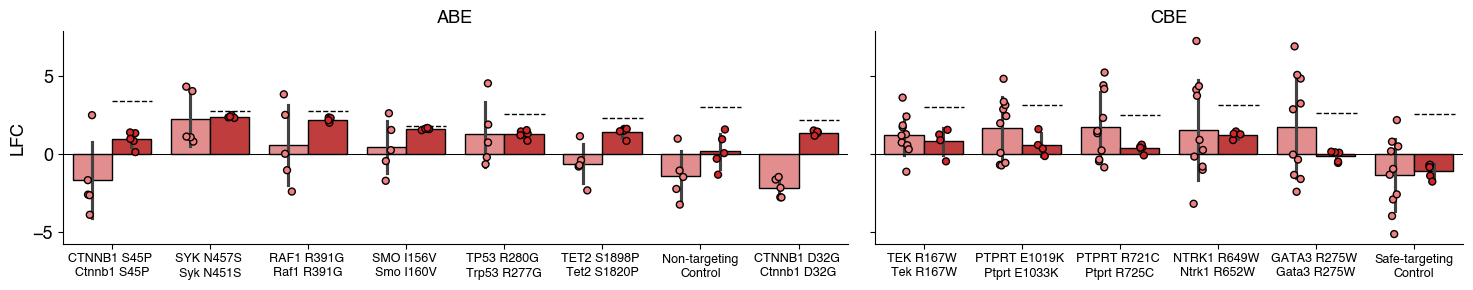

In [ ]:
val_CBE['Condition'] = 'Validation'
CBE1 = pd.concat((screen_CBE_reformat, val_CBE))

val_ABE['Condition'] = 'Validation'
ABE1 = pd.concat((screen_ABE_reformat, val_ABE))


fig, ax = plt.subplots(1,2, figsize=(15,3), width_ratios=[8,6], sharey=True)
tissue = 'Meninges'

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]
pal_iv = ['lightgrey', 'tab:grey']
pal_spleen = ['cadetblue', 'tab:blue']
pal_bon = ['slateblue', 'indigo']
pal_men = ['lightcoral', 'tab:red']

pal_chosen = pal_men
sns.stripplot(data=ABE1[ABE1['Tissue']==tissue], x='gRNA_id', y='LFC', hue='Condition', dodge=True, legend=False, ax=ax[0], palette=pal_chosen, edgecolor='black', linewidth=1, order=g_order_ABE)
sns.barplot(data=ABE1[ABE1['Tissue']==tissue], x='gRNA_id', y='LFC', hue='Condition', errorbar='sd', legend=False,ax=ax[0], edgecolor='black', palette=pal_chosen, linewidth=1, order=g_order_ABE)
sns.stripplot(data=CBE1[CBE1['Tissue']==tissue], x='gRNA_id', y='LFC', hue='Condition', dodge=True, legend=False, ax=ax[1], edgecolor='black', palette=pal_chosen, linewidth=1, order=g_order_CBE)
sns.barplot(data=CBE1[CBE1['Tissue']==tissue], x='gRNA_id', y='LFC', hue='Condition', errorbar='sd',legend=False,ax=ax[1], edgecolor='black', palette=pal_chosen, linewidth=1, order=g_order_CBE)


ax[0].axhline(0, color='black',  linewidth=.75)
ax[1].axhline(0, color='black', linewidth=.75)

#plot theoretical maximum LFC for each gRNA given the initial BFP+%
initial = validation_merged[validation_merged['Timepoint']=='Initial']
for i, val in enumerate(g_order_ABE):
    init = initial.loc[initial['gRNA_id']==val, 'Percent_population'].values[0]
    ax[0].axhline(np.log2(100/init), xmin=0+i/8+1/16, xmax=i/8 + 1/8-1/90, color='black', linestyle='dashed', linewidth=1)

for i, val in enumerate(g_order_CBE):
    init = initial.loc[initial['gRNA_id']==val, 'Percent_population'].values[0]
    ax[1].axhline(np.log2(100/init), xmin=0+i/6+1/12, xmax=i/6 + 1/6-1/70, color='black', linestyle='dashed', linewidth=1)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)

ax[0].tick_params(axis='x', which='major', labelsize=9)
ax[0].tick_params(axis='y', which='major', labelsize=13)

ax[1].tick_params(axis='x', which='major', labelsize=9)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('LFC', fontsize=13)

ax[0].set_xticklabels(names_ABE2)
ax[1].set_xticklabels(names_CBE2)
ax[0].set_title('ABE', fontsize=13)
ax[1].set_title('CBE', fontsize=13)

fig.tight_layout()
#fig.savefig(f'figures/{tissue}_barplot_validation_v2_w_max.pdf')

In [168]:
validation_merged[validation_merged['Timepoint']=='Initial']

,sgRNA,Percent_population,Timepoint,Tissue,FoldChange,LFC,gRNA_id,Gene,gene_name_h,HGVSp_m,HGVSp_h,classification,Editor,Name
0,ABE1,16.60,Initial,In Vitro,1.0,0.0,gRNA_12604,Trp53,TP53,R277G,R280G,targeting guide,ABE,TP53 R280G \nTrp53 R277G
19,ABE10,14.30,Initial,In Vitro,1.0,0.0,gRNA_12164,Syk,SYK,N451S,N457S,targeting guide,ABE,SYK N457S \nSyk N451S
35,ABE15,20.30,Initial,In Vitro,1.0,0.0,gRNA_12386,Tet2,TET2,S1820P,S1898P,targeting guide,ABE,TET2 S1898P \nTet2 S1820P
54,ABE17,28.60,Initial,In Vitro,1.0,0.0,gRNA_11607,Smo,SMO,I160V,I156V,targeting guide,ABE,SMO I156V \nSmo I160V
73,ABE2,12.00,Initial,In Vitro,1.0,0.0,gRNA_13607,non_target,NaN,Non-coding,NaN,non-targeting control,ABE,nan nan \nnon_target Non-coding
92,ABE3,21.30,Initial,In Vitro,1.0,0.0,gRNA_2458,Ctnnb1,CTNNB1,D32G,D32G,targeting guide,ABE,CTNNB1 D32G \nCtnnb1 D32G
111,ABE6,14.60,Initial,In Vitro,1.0,0.0,gRNA_10342,Raf1,RAF1,R391G,R391G,targeting guide,ABE,RAF1 R391G \nRaf1 R391G
127,ABE8,9.39,Initial,In Vitro,1.0,0.0,gRNA_2474,Ctnnb1,CTNNB1,S45P,S45P,targeting guide,ABE,CTNNB1 S45P \nCtnnb1 S45P
146,CBE11,11.20,Initial,In Vitro,1.0,0.0,gRNA_8280,Ntrk1,NTRK1,R652W,R649W,targeting guide,CBE,NTRK1 R649W \nNtrk1 R652W
162,CBE12,11.40,Initial,In Vitro,1.0,0.0,gRNA_10131,Ptprt,PTPRT,E1033K,E1019K,targeting guide,CBE,PTPRT E1019K \nPtprt E1033K


In [195]:
np.log2(100/28.6)

1.8059129478836975

<Axes: xlabel='gRNA_id', ylabel='LFC'>

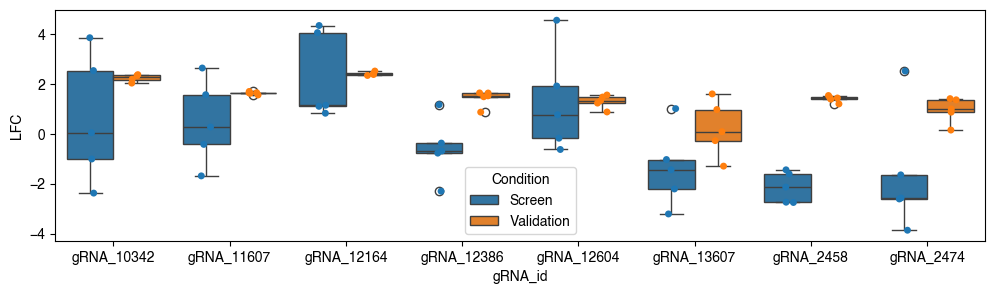

In [90]:
val_ABE['Condition'] = 'Validation'
ABE1 = pd.concat((screen_ABE_reformat, val_ABE))

fig, ax = plt.subplots(figsize=(12,3))
tissue = 'Meninges'
sns.stripplot(data=ABE1[ABE1['Tissue']==tissue], x='gRNA_id', y='LFC', hue='Condition', dodge=True, legend=False)
sns.boxplot(data=ABE1[ABE1['Tissue']==tissue], x='gRNA_id', y='LFC', hue='Condition')